# Import Packages

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #visualization
import seaborn as sns #visualization
import statsmodels.api as sm #linear regression
import sklearn
import datetime 
from sklearn import preprocessing #scaling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score #parameter tuning
from sklearn.model_selection import RepeatedKFold #parameter tuning
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import KFold, RepeatedKFold,GridSearchCV #parameter tuning
from sklearn.ensemble import ExtraTreesRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import tree
import catboost as cb
import xgboost as xg
from sklearn.preprocessing import PolynomialFeatures

loading the dataset

In [252]:
data=pd.read_excel('archive/Data_Train.xlsx')

In [253]:
data.info() #summary of dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


## Functions

In [254]:
def compare_price(data,column,flag):
    compare_set=data.groupby(column, as_index=False)['Price'].mean()
    res1='number of observations for each {}:\n'.format(column)
    print(res1,data[column].value_counts())
    res2='mean of price for each {}:\n'.format(column)
    print(res2,compare_set)
    if(flag):
        return compare_set


In [255]:
def box_bar_plot(data,column):
    compare_set=compare_price(data,column,True)
    sns.set(rc={'figure.figsize':(30,7)})
    sns.barplot(data=compare_set, x=column, y="Price").set(title='Prices for each {}'.format(column))
    plt.show()
    sns.boxplot(data=data, x=column,y="Price").set(title='Prices for each {}'.format(column))
    plt.show()
    

In [256]:
def scale_data(data):
    min_max_scaler = preprocessing.MinMaxScaler()
    columns_list=data.columns
    data_scaled = min_max_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns=columns_list)
    return data_scaled

In [257]:
def descale_data(data):
    min_max_scaler = preprocessing.MinMaxScaler()
    columns_list=data.columns
    data_scaled = min_max_scaler.fit_transform(data)
    dedata_scaled= min_max_scaler.inverse_transform(data_scaled)
    dedata_scaled = pd.DataFrame(dedata_scaled, columns=columns_list)
    return dedata_scaled
    

# Data Understanding and Feature Engineering

### Price

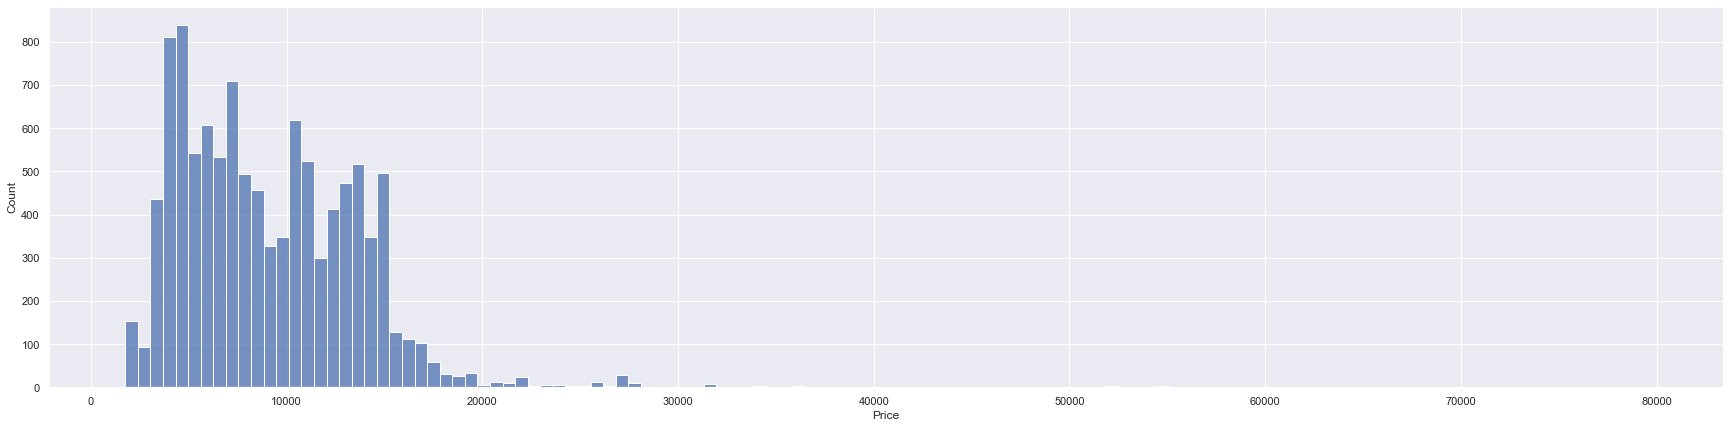

In [258]:
sns.histplot(data=data, x="Price")
data=data[data['Price']<17000]

### Airline

In [259]:
compare_price(data,'Airline',False)


number of observations for each Airline:
 Jet Airways                          3628
IndiGo                               2050
Air India                            1707
Multiple carriers                    1138
SpiceJet                              817
Vistara                               475
Air Asia                              319
GoAir                                 191
Multiple carriers Premium economy      13
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64
mean of price for each Airline:
                               Airline         Price
0                            Air Asia   5590.260188
1                           Air India   9294.950205
2                               GoAir   5634.544503
3                              IndiGo   5653.040000
4                         Jet Airways  11032.034179
5                   Multiple carriers  10440.344464
6   Multiple carriers Premium economy  11418.846154
7                  

In [260]:
data=data[data['Airline']!='Multiple carriers Premium economy']
data=data[data['Airline']!='Jet Airways Business']
data=data[data['Airline']!='Vistara Premium economy']
data=data[data['Airline']!='Trujet']
data=data.reset_index()

number of observations for each Airline:
 Jet Airways          3628
IndiGo               2050
Air India            1707
Multiple carriers    1138
SpiceJet              817
Vistara               475
Air Asia              319
GoAir                 191
Name: Airline, dtype: int64
mean of price for each Airline:
              Airline         Price
0           Air Asia   5590.260188
1          Air India   9294.950205
2              GoAir   5634.544503
3             IndiGo   5653.040000
4        Jet Airways  11032.034179
5  Multiple carriers  10440.344464
6           SpiceJet   4315.116279
7            Vistara   7686.492632


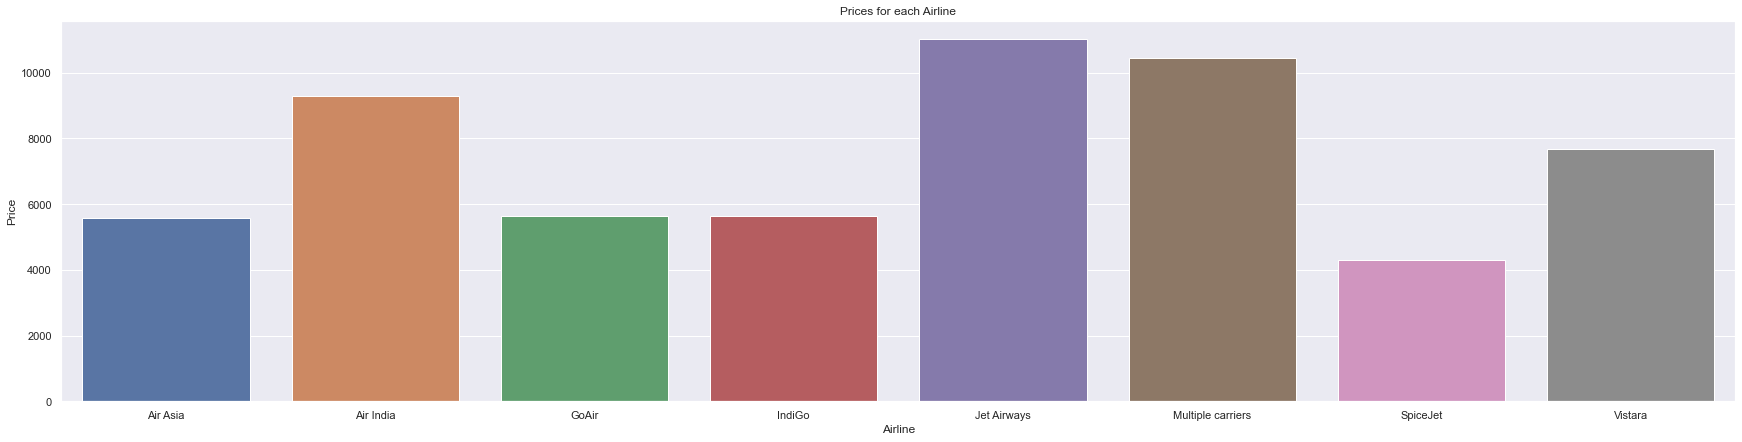

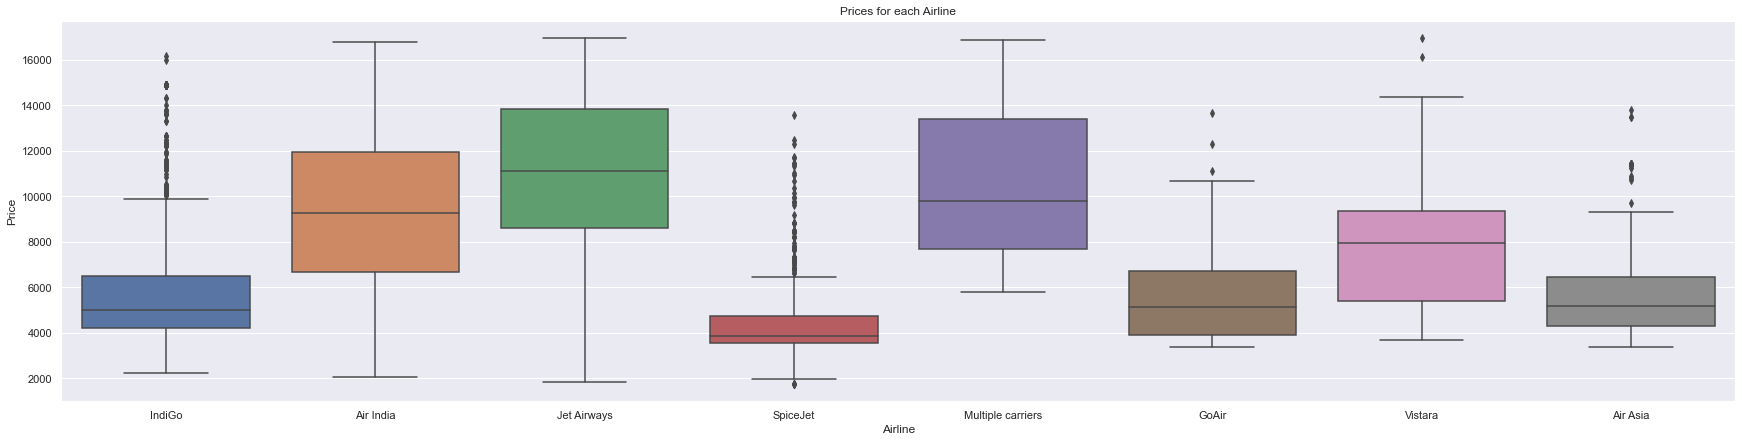

In [261]:
#visualization
box_bar_plot(data,'Airline')

In [262]:
data=pd.get_dummies(data, columns=['Airline'])

### Date_of_Journey

In [263]:
d1=datetime.datetime(2019, 3, 1)
d2=datetime.datetime(2019, 3, 16)
d3=datetime.datetime(2019, 4, 1)
d4=datetime.datetime(2019, 4, 16)
d5=datetime.datetime(2019, 5, 1)
d6=datetime.datetime(2019, 5, 16)
d7=datetime.datetime(2019, 6, 1)
d8=datetime.datetime(2019, 6, 16)

number of observations for each Date_Group:
 First_6     2478
First_5     1790
Second_5    1664
First_3     1221
Second_3    1185
Second_6     910
First_4      742
Second_4     335
Name: Date_Group, dtype: int64
mean of price for each Date_Group:
   Date_Group         Price
0    First_3  10328.818182
1    First_4   5985.959569
2    First_5   8728.123464
3    First_6   9157.671106
4   Second_3   8045.614346
5   Second_4   5258.692537
6   Second_5   9473.695913
7   Second_6   7656.598901


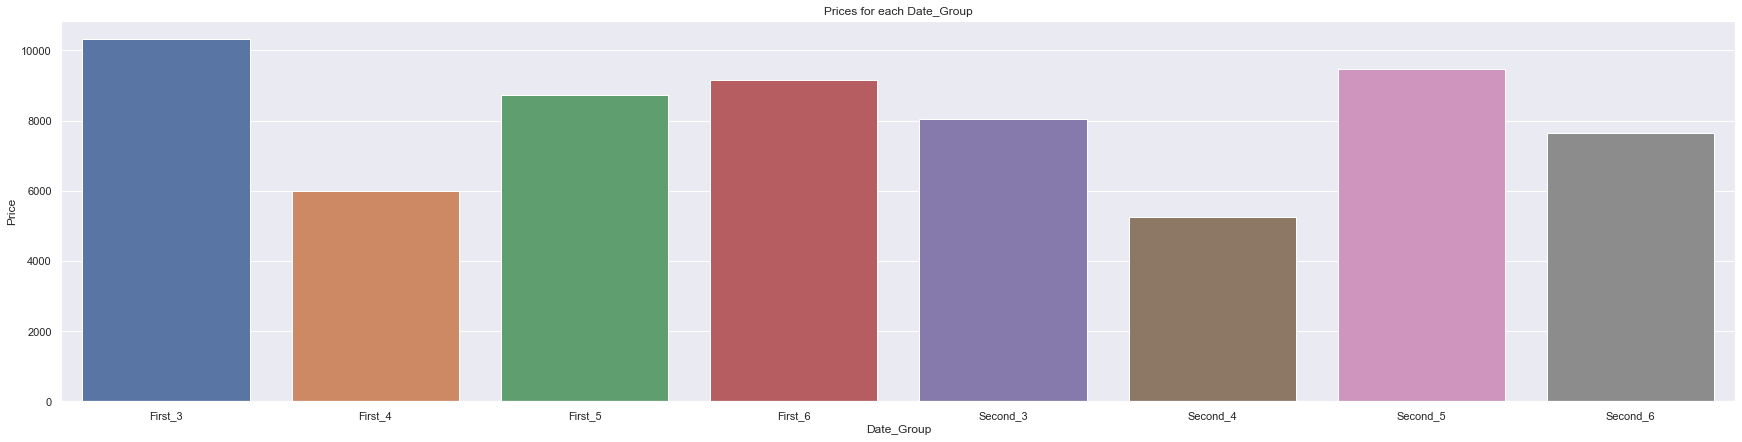

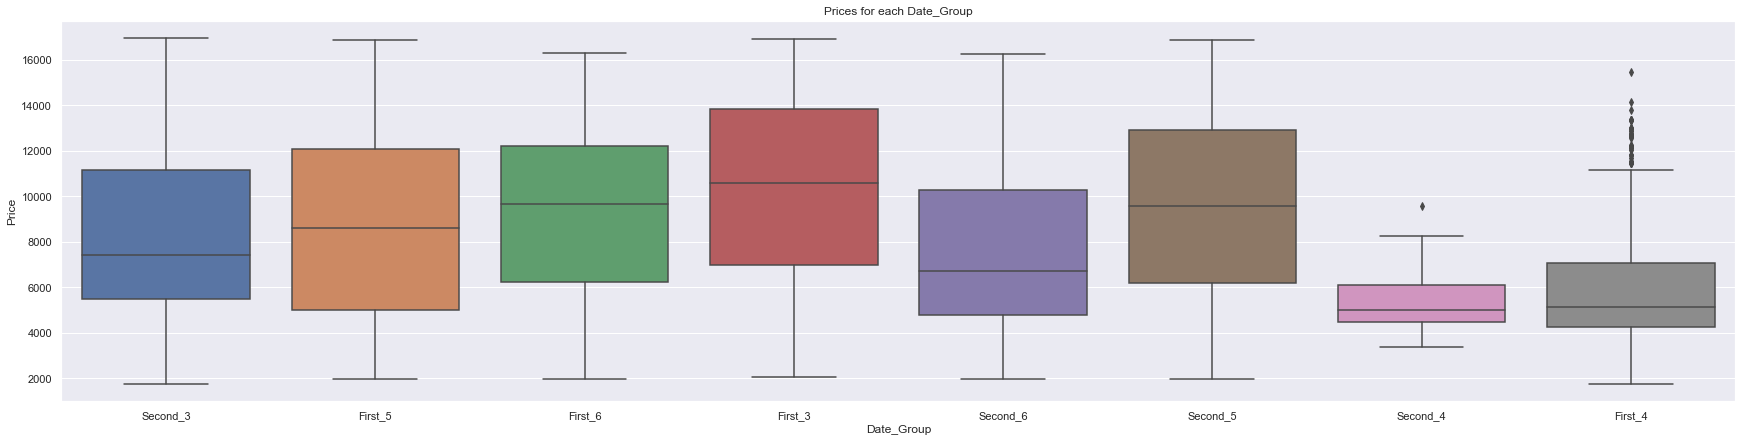

In [264]:
data=data.reset_index()
for i in range(len(data)):
    date_i=datetime.datetime.strptime(str(data.at[i,'Date_of_Journey']), '%d/%m/%Y')
    if date_i>=d1 and date_i<d2:
        data.at[i,'Date_Group']='First_3'
    elif date_i>=d2 and date_i<d3:
        data.at[i,'Date_Group']='Second_3'
    elif date_i>=d3 and date_i<d4:
        data.at[i,'Date_Group']='First_4'
    elif date_i>=d4 and date_i<d5:
        data.at[i,'Date_Group']='Second_4'
    elif date_i>=d5 and date_i<d6:
        data.at[i,'Date_Group']='First_5'
    elif date_i>=d6 and date_i<d7:
        data.at[i,'Date_Group']='Second_5'
    elif date_i>=d7 and date_i<d8:
        data.at[i,'Date_Group']='First_6'
    else:
        data.at[i,'Date_Group']='Second_6'

box_bar_plot(data,'Date_Group')
data=pd.get_dummies(data, columns=['Date_Group'])
data=data.drop(columns=['Date_of_Journey'])
data=data.drop(columns=['index'])

### Source

number of observations for each Source:
 Delhi       4361
Kolkata     2868
Banglore    2042
Mumbai       675
Chennai      379
Name: Source, dtype: int64
mean of price for each Source:
      Source         Price
0  Banglore   6770.008815
1   Chennai   4739.298153
2     Delhi  10195.144462
3   Kolkata   9144.703626
4    Mumbai   4574.788148


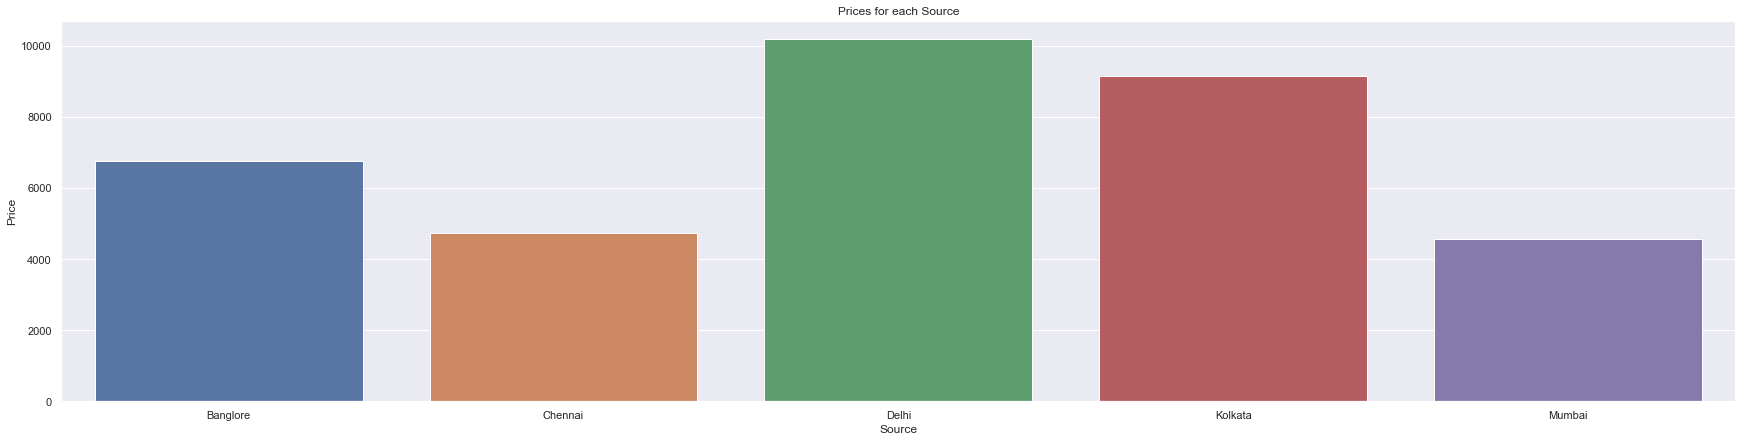

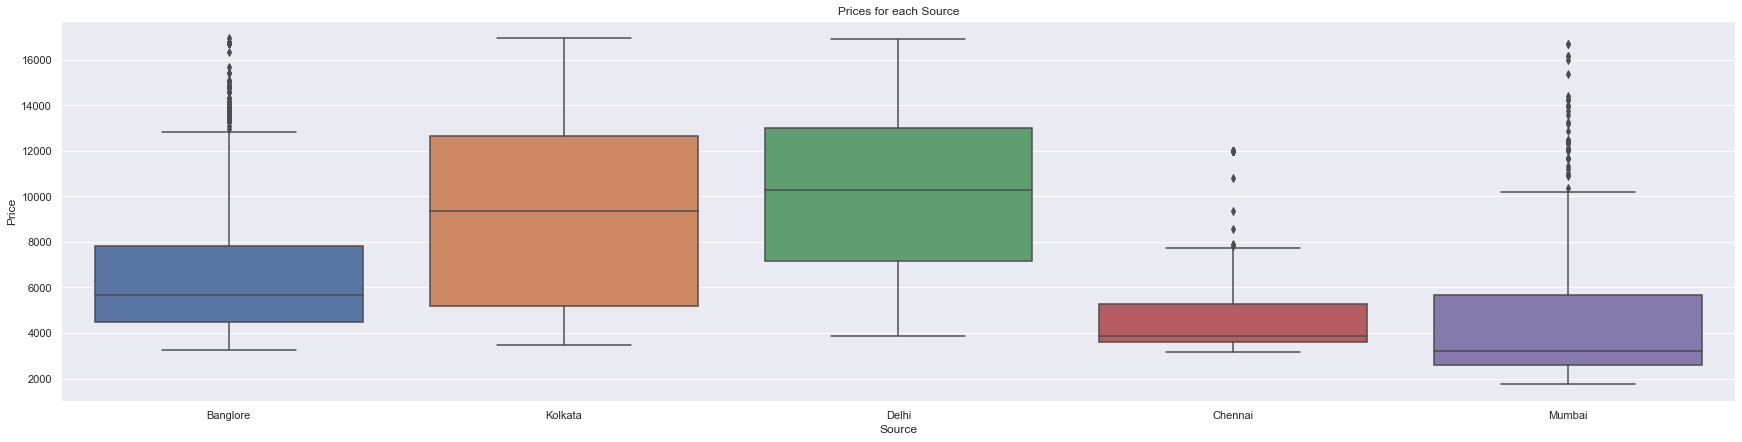

In [265]:
box_bar_plot(data,'Source')

In [266]:
data=pd.get_dummies(data, columns=['Source'])

### Destination

number of observations for each Destination:
 Cochin       4361
Banglore     2868
Delhi        1264
New Delhi     778
Hyderabad     675
Kolkata       379
Name: Destination, dtype: int64
mean of price for each Destination:
   Destination         Price
0    Banglore   9144.703626
1      Cochin  10195.144462
2       Delhi   5143.265823
3   Hyderabad   4574.788148
4     Kolkata   4739.298153
5   New Delhi   9412.943445


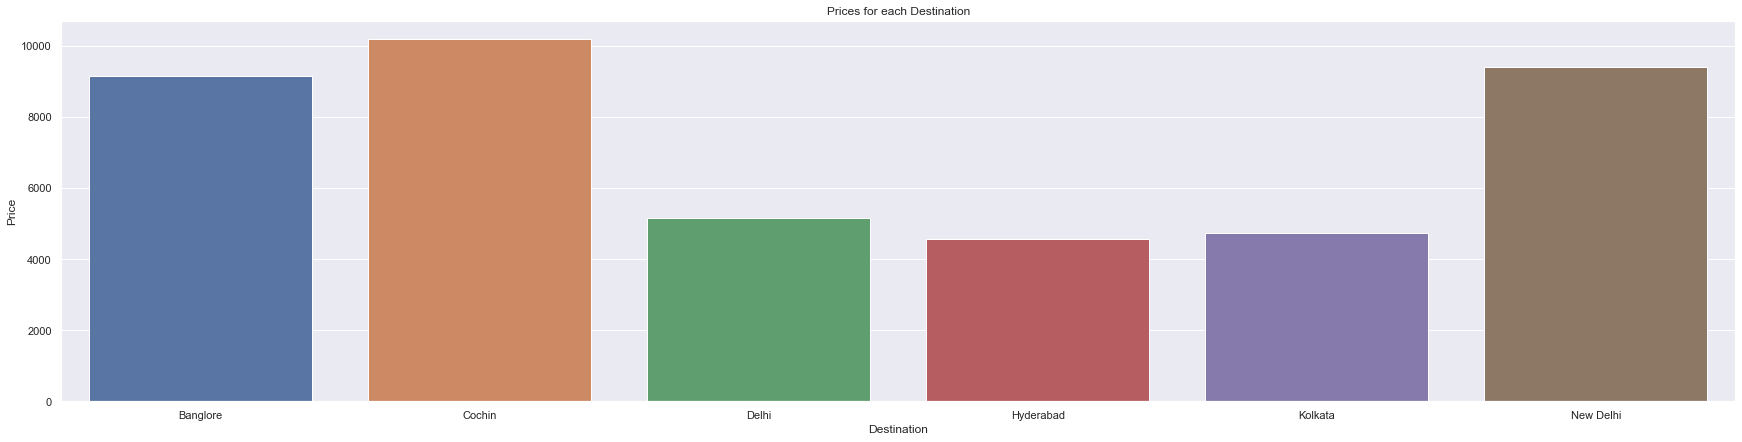

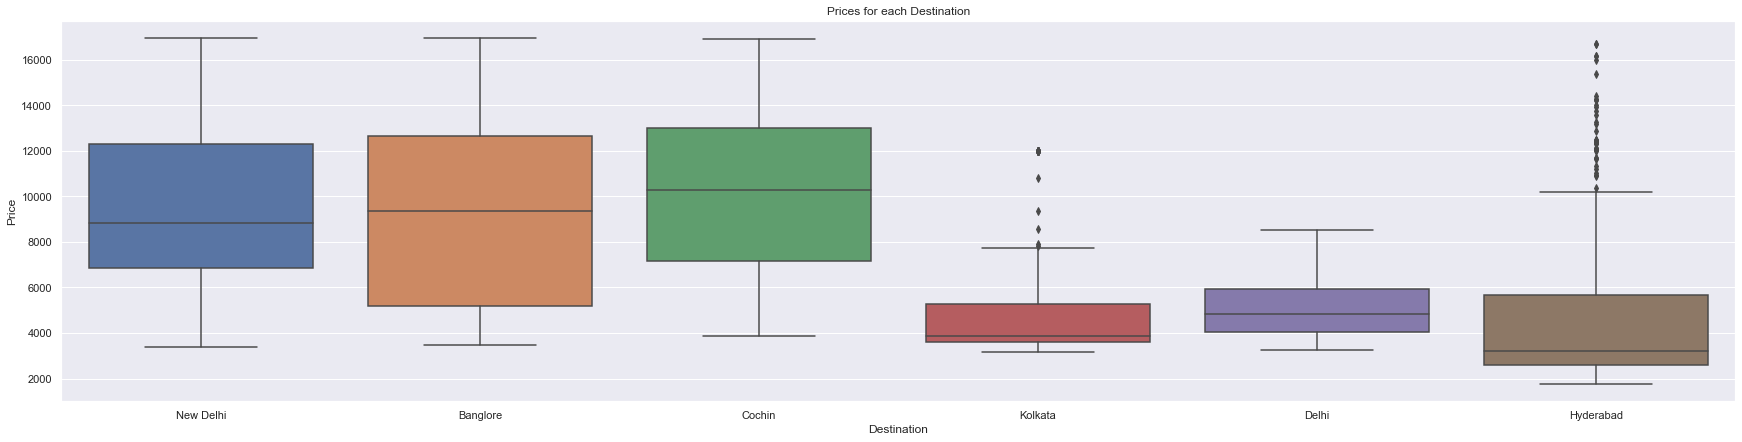

In [267]:
box_bar_plot(data,'Destination')

In [268]:
data=pd.get_dummies(data, columns=['Destination'])

### Dep_Time

In [269]:
data['Dep_H'] = data['Dep_Time'].apply(lambda x: x.split(':')[0])
data['Dep_H']=data['Dep_H'].astype(str).astype(int)

data['Dep_M'] = data['Dep_Time'].apply(lambda x: x.split(':')[1])
data['Dep_M']=data['Dep_M'].astype(str).astype(int)

data=data.drop(columns=['Dep_Time'])

### Arrival_Time

In [270]:
data['Arrival_Time'] = data['Arrival_Time'].apply(lambda x: x[0:5])
data['Arr_H'] = data['Arrival_Time'].apply(lambda x: x.split(':')[0])
data['Arr_H']=data['Arr_H'].astype(str).astype(int)

data['Arr_M'] = data['Arrival_Time'].apply(lambda x: x.split(':')[1])
data['Arr_M']=data['Arr_M'].astype(str).astype(int)

data=data.drop(columns=['Arrival_Time'])

### Duration

In [271]:
for i in range(len(data)):
    try:
        s=data.at[i,'Duration'].split('h')
        ans=int(s[0])
        data.at[i,'Duration']=ans
    except:
        data.at[i,'Duration']=0

data['Duration']=data['Duration'].astype(str).astype(int)
data=data[data['Duration']!=0]

### Total_Stops

In [272]:
data.replace('non-stop', 0, inplace=True)
data.replace('1 stop', 1, inplace=True)
data.replace('2 stops', 2, inplace=True)
data.replace('3 stops', 3, inplace=True)
data.replace('4 stops', 4, inplace=True)

### Additional_Info

In [273]:
data.Additional_Info.value_counts()

No info                         8014
In-flight meal not included     1976
No check-in baggage included     320
1 Long layover                     7
Change airports                    4
No Info                            3
Red-eye flight                     1
Name: Additional_Info, dtype: int64

In [274]:
data=data[data['Additional_Info']!='1 Long layover']
data=data[data['Additional_Info']!='Change airports']
data=data[data['Additional_Info']!='Red-eye flight']
data.replace('No Info', 'No info', inplace=True)


In [275]:
data=pd.get_dummies(data, columns=['Additional_Info'])

In [276]:
data=data.drop(columns=['level_0','Route'])
data.head()

,Duration,Total_Stops,Price,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_SpiceJet,...,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Dep_H,Dep_M,Arr_H,Arr_M,Additional_Info_In-flight meal not included,Additional_Info_No check-in baggage included,Additional_Info_No info
0,2,0.0,3897,0,0,0,1,0,0,0,...,0,0,1,22,20,1,10,0,0,1
1,7,2.0,7662,0,1,0,0,0,0,0,...,0,0,0,5,50,13,15,0,0,1
2,19,2.0,13882,0,0,0,0,1,0,0,...,0,0,0,9,25,4,25,0,0,1
3,5,1.0,6218,0,0,0,1,0,0,0,...,0,0,0,18,5,23,30,0,0,1
4,4,1.0,13302,0,0,0,1,0,0,0,...,0,0,1,16,50,21,35,0,0,1


### Scale data

In [277]:
data_scaled=scale_data(data)

In [278]:
test=descale_data(data_scaled)

In [279]:
data_scaled.head()

,Duration,Total_Stops,Price,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Multiple carriers,Airline_SpiceJet,...,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Dep_H,Dep_M,Arr_H,Arr_M,Additional_Info_In-flight meal not included,Additional_Info_No check-in baggage included,Additional_Info_No info
0,0.024390,0.000000,0.140778,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.956522,0.363636,0.043478,0.181818,0.0,0.0,1.0
1,0.146341,0.666667,0.388688,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.217391,0.909091,0.565217,0.272727,0.0,0.0,1.0
2,0.439024,0.666667,0.798249,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.391304,0.454545,0.173913,0.454545,0.0,0.0,1.0
3,0.097561,0.333333,0.293606,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.782609,0.090909,1.000000,0.545455,0.0,0.0,1.0
4,0.073171,0.333333,0.760058,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.695652,0.909091,0.913043,0.636364,0.0,0.0,1.0


<AxesSubplot:>

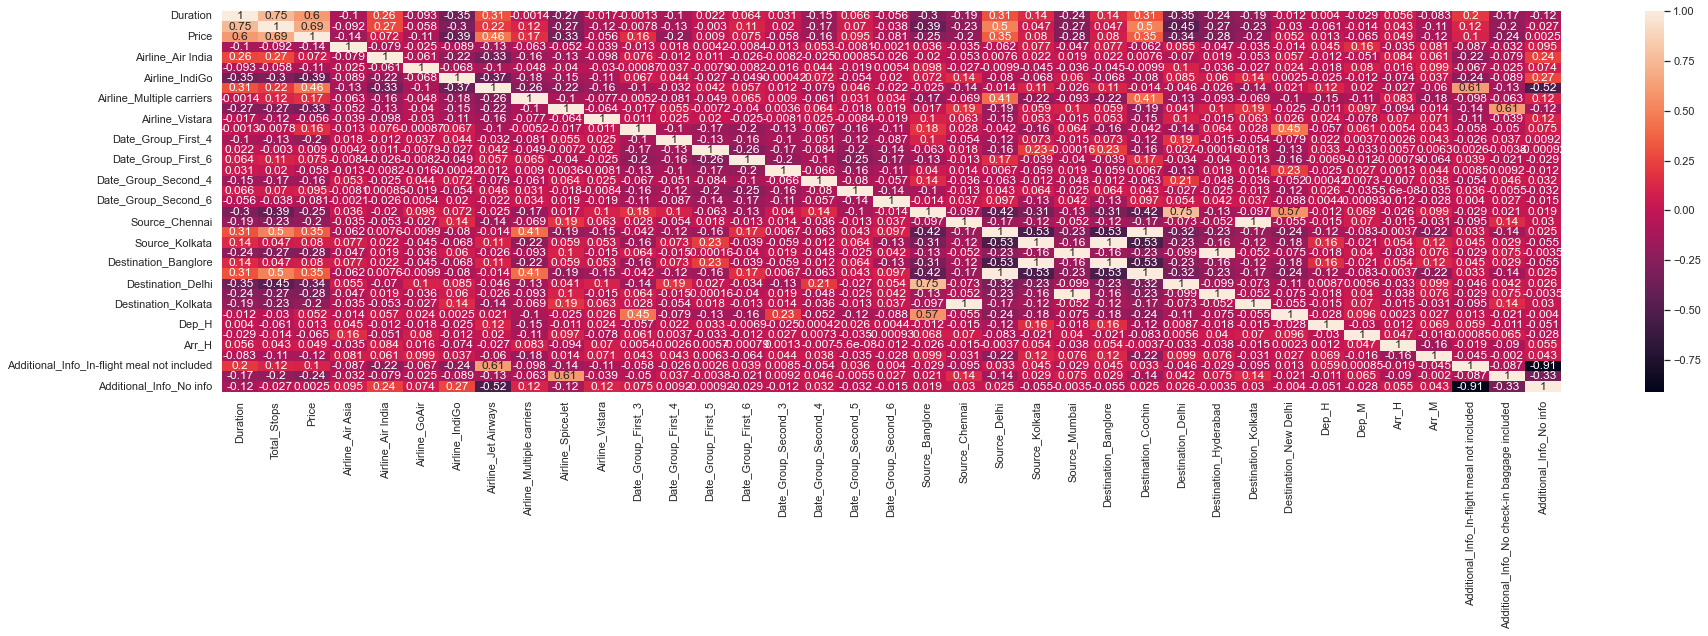

In [280]:
matrix = data.corr()
sns.heatmap(matrix, annot=True)

# Models

In [281]:
results_dict={}

### linear regression using statmodels

In [282]:
def fit_OLS_model(data_scaled,model):
    data_scaled=data_scaled.dropna()
    X=data_scaled.drop(columns=['Price'])
    y=data_scaled.Price
    X = sm.add_constant(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)
    function_model=sm.OLS(y_train,X_train).fit()
    prediction=function_model.predict(X_test)
    sns.scatterplot(x=prediction, y=y_test).set(title='Prediction vs True Value')
    plt.xlabel('Estimated Price')
    plt.show()
    return function_model.rsquared, function_model.summary()




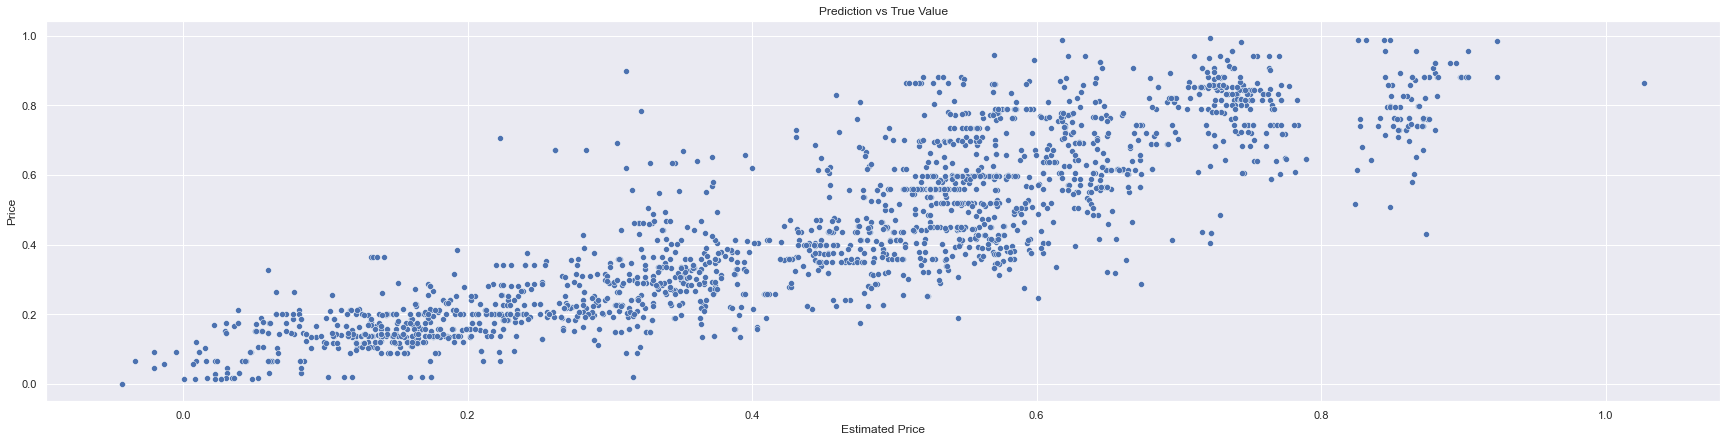

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     977.6
Date:                Sun, 01 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:05:27   Log-Likelihood:                 5632.5
No. Observations:                8249   AIC:                        -1.121e+04
Df Residuals:                    8221   BIC:                        -1.101e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            0.0941      0.003     27.506      0.000       0.087       0.101
Duration                                         0.0570      0.011      5.322      0.000       0.036       0.078
Total_Stops                                      0.4173      0.011     37.713      0.000       0.396       0.439
Airline_Air Asia                                -0.0995      0.007    -13.626      0.000      -0.114      -0.085
Airline_Air India                                0.0143      0.004      3.537      0.000       0.006       0.022
Airline_GoAir                                   -0.0850      0.009     -9.392      0.000      -0.103      -0.067
Airline_IndiGo                                  -0.0785      0.003    -22.902      0.000      -0.085      -0.072
Airline_Jet Airways                              0.2766      0.004     75.636      0.000       0.269       0.284
Airline_Multiple carriers                        0.1298      0.005     28.027      0.000       0.121       0.139
Airline_SpiceJet                                -0.1055      0.006    -18.211      0.000      -0.117      -0.094
Airline_Vistara                                  0.0419      0.006      7.008      0.000       0.030       0.054
Date_Group_First_3                               0.1716      0.004     39.103      0.000       0.163       0.180
Date_Group_First_4                              -0.0680      0.005    -13.905      0.000      -0.078      -0.058
Date_Group_First_5                               0.0102      0.003      3.023      0.003       0.004       0.017
Date_Group_First_6                               0.0092      0.003      3.089      0.002       0.003       0.015
Date_Group_Second_3                             -0.0265      0.004     -6.558      0.000      -0.034      -0.019
Date_Group_Second_4                             -0.0225      0.007     -3.182      0.001      -0.036      -0.009
Date_Group_Second_5                              0.0318      0.003      9.354      0.000       0.025       0.038
Date_Group_Second_6                             -0.0117      0.004     -2.694      0.007      -0.020      -0.003
Source_Banglore                                  0.0224      0.002     10.277      0.000       0.018       0.027
Source_Chennai                                   0.0192      0.003      5.914      0.000       0.013       0.026
Source_Delhi                                     0.0417      0.002     22.672      0.000       0.038       0.045
Source_Kolkata                                   0.0473      0.002     27.089      0.000       0.044       0.051
Source_Mumbai                                   -0.0365      0.003    -14.414      0.000      -0.041      -0.032
Destination_Banglore            

In [283]:
r_1,sum_1=fit_OLS_model(data_scaled,'OLS')
sum_1

### Functions for sklearn modeling

In [284]:
def split_data(data_scaled):
    data_scaled=data_scaled.dropna()
    X=data_scaled.drop(columns=['Price'])
    y=data_scaled.Price
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)
    return X_train, X_test, y_train, y_test

In [285]:
def prediction(model,X_test,y_test):
    score=model.score(X_test,y_test)
    prediction=model.predict(X_test)
    sns.scatterplot(x=prediction, y=y_test)
    plt.xlabel('Estimated Price')
    plt.show()
    return score


### Linear regression

In [286]:
def fit_OLS_model_sk(X_train, y_train):
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    return reg

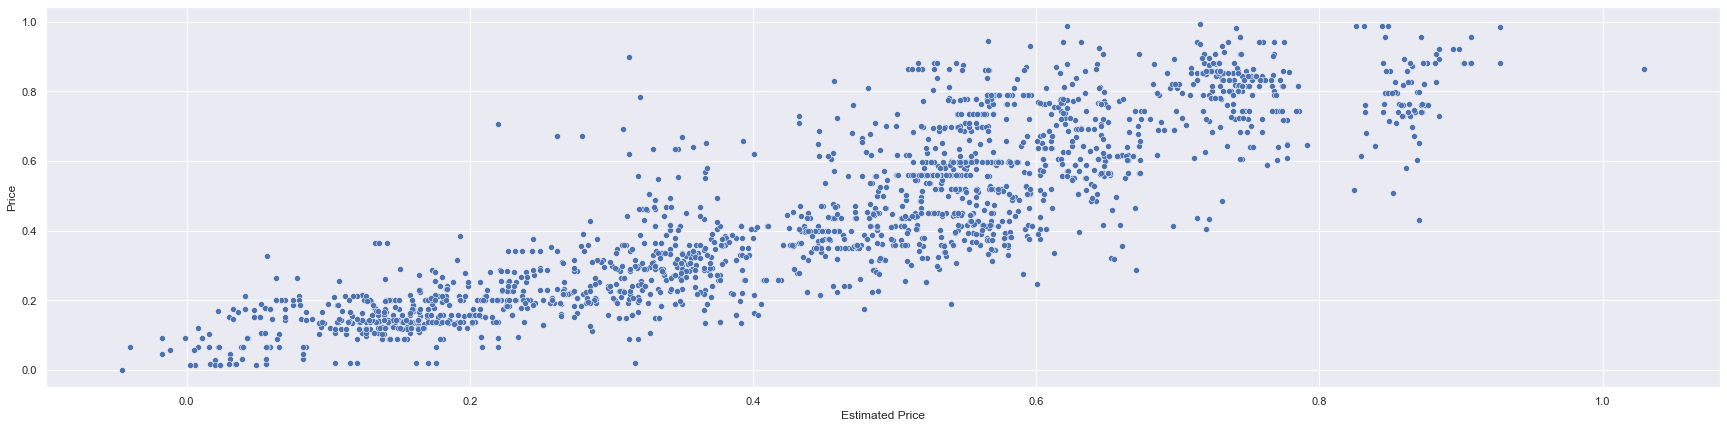

In [287]:
X_train, X_test, y_train, y_test=split_data(data_scaled)
my_OLS=fit_OLS_model_sk(X_train, y_train)
my_OLS_score=prediction(my_OLS,X_test,y_test)
results_dict['OLS']=my_OLS_score

### Lasso regression

In [288]:
def fit_Lasso_model(X_train, y_train):
    lasso = LassoCV(cv=5, random_state=72, max_iter=8000)
    lasso.fit(X_train, y_train)
    score=lasso.score(X_train, y_train)
    return lasso.alpha_,lasso

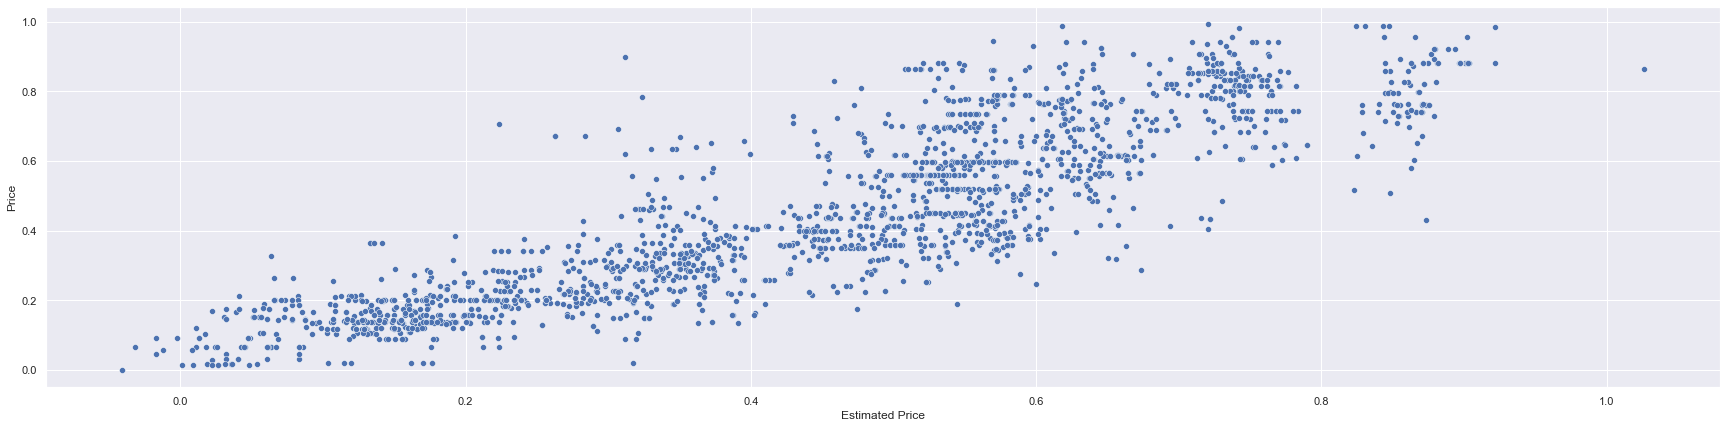

In [289]:
X_train, X_test, y_train, y_test=split_data(data_scaled)
a,my_lasso=fit_Lasso_model(X_train, y_train)
my_lasso_score=prediction(my_lasso,X_test,y_test)
results_dict['Lasso']=my_lasso_score

### Ridge regression

In [290]:
def fit_Ridge_model(X_train, y_train):
    ridge = RidgeCV(cv=5, random_state=72, max_iter=8000)
    ridge.fit(X_train, y_train)
    score=ridge.score(X_train, y_train)
    return ridge.alpha_,ridge

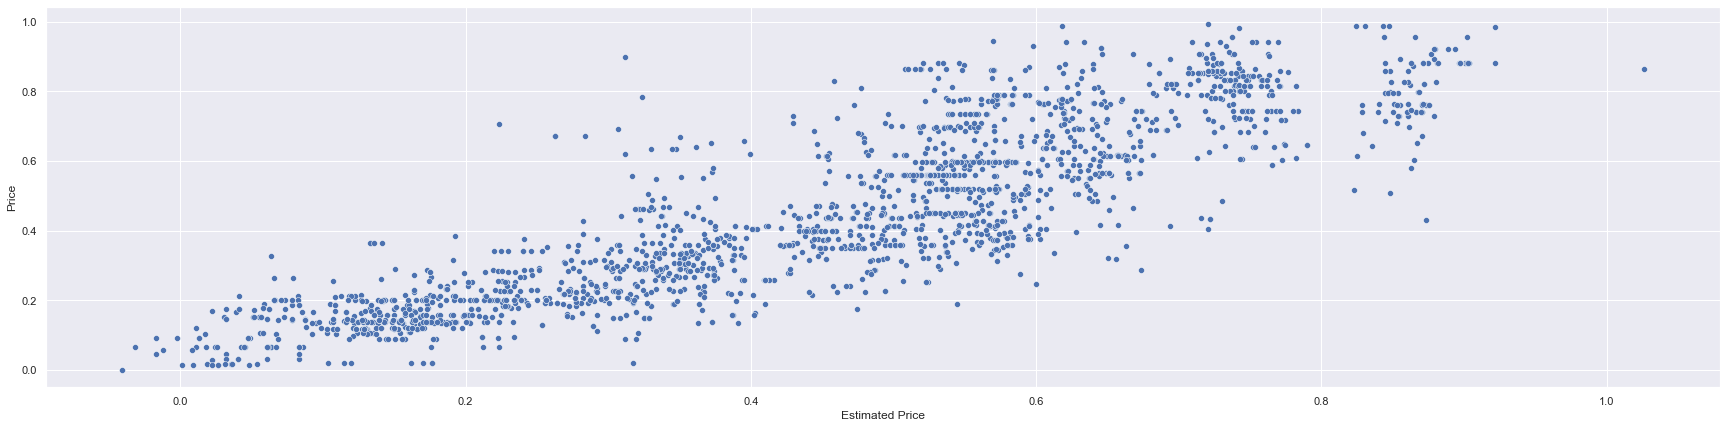

In [291]:
X_train, X_test, y_train, y_test=split_data(data_scaled)
a,my_ridge=fit_Lasso_model(X_train, y_train)
my_ridge_score=prediction(my_ridge,X_test,y_test)
results_dict['Ridge']=my_ridge_score

### Decision tree regression

In [ ]:
def param_decision_tree_model(X_train,y_train):
    parameters={
    "criterion":["squared_error", "friedman_mse"],
    "splitter" : ["best", "random"],
    "max_depth":[1,2,3,4,5,None],
    "min_samples_leaf":[1,2,3,None],
    "min_weight_fraction_leaf":[0.1,0.2,0.5,None],
    "max_features":["auto", "sqrt",None],
    "max_leaf_nodes":[2,5,10,20,None]}
    reg_tree=DecisionTreeRegressor()
    tuning_model=GridSearchCV(reg_tree,param_grid=parameters,scoring='neg_mean_squared_error',cv=5,verbose=3)
    tuning_model.fit(X_train,y_train)
    return tuning_model.best_score_,tuning_model.best_params_

DTR_score,DTR_param=param_decision_tree_model(X_train,y_train)

In [292]:
def fit_decision_tree_model(X_train,y_train):
    reg_tree = DecisionTreeRegressor(max_depth=5)
    reg_tree.fit(X_train, y_train)
    return reg_tree.get_params(), reg_tree


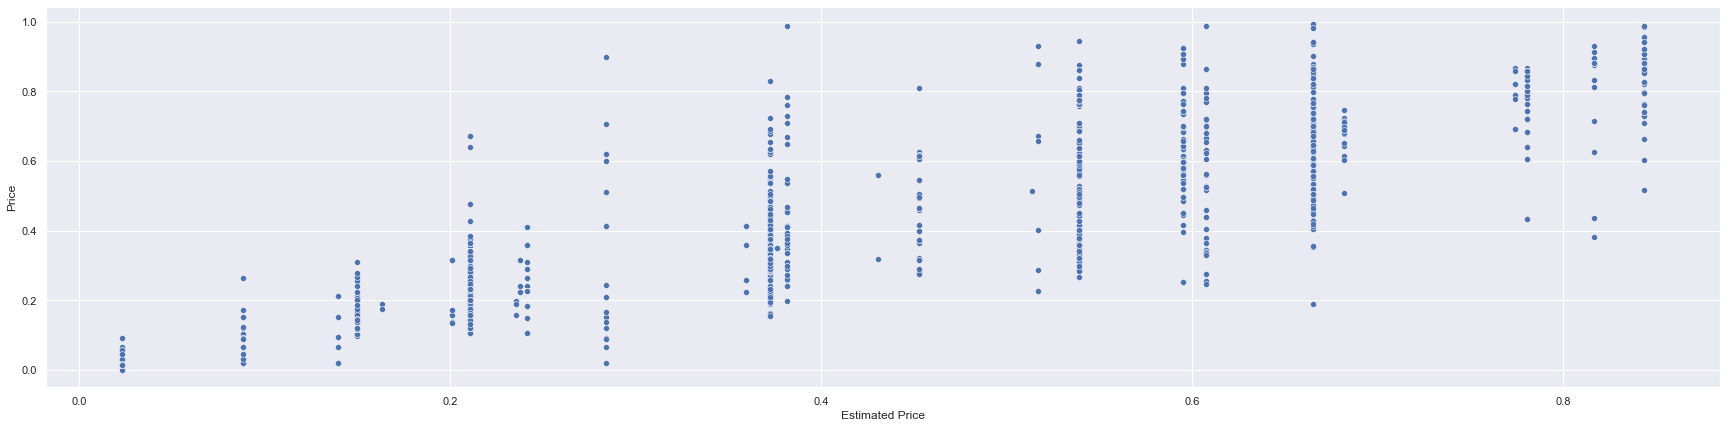

In [293]:
X_train, X_test, y_train, y_test=split_data(data_scaled)
my_DTR_params,my_DTR=fit_decision_tree_model(X_train, y_train)
my_DTR_params_score=prediction(my_DTR,X_test,y_test)
results_dict['Decision tree regression']=my_DTR_params_score

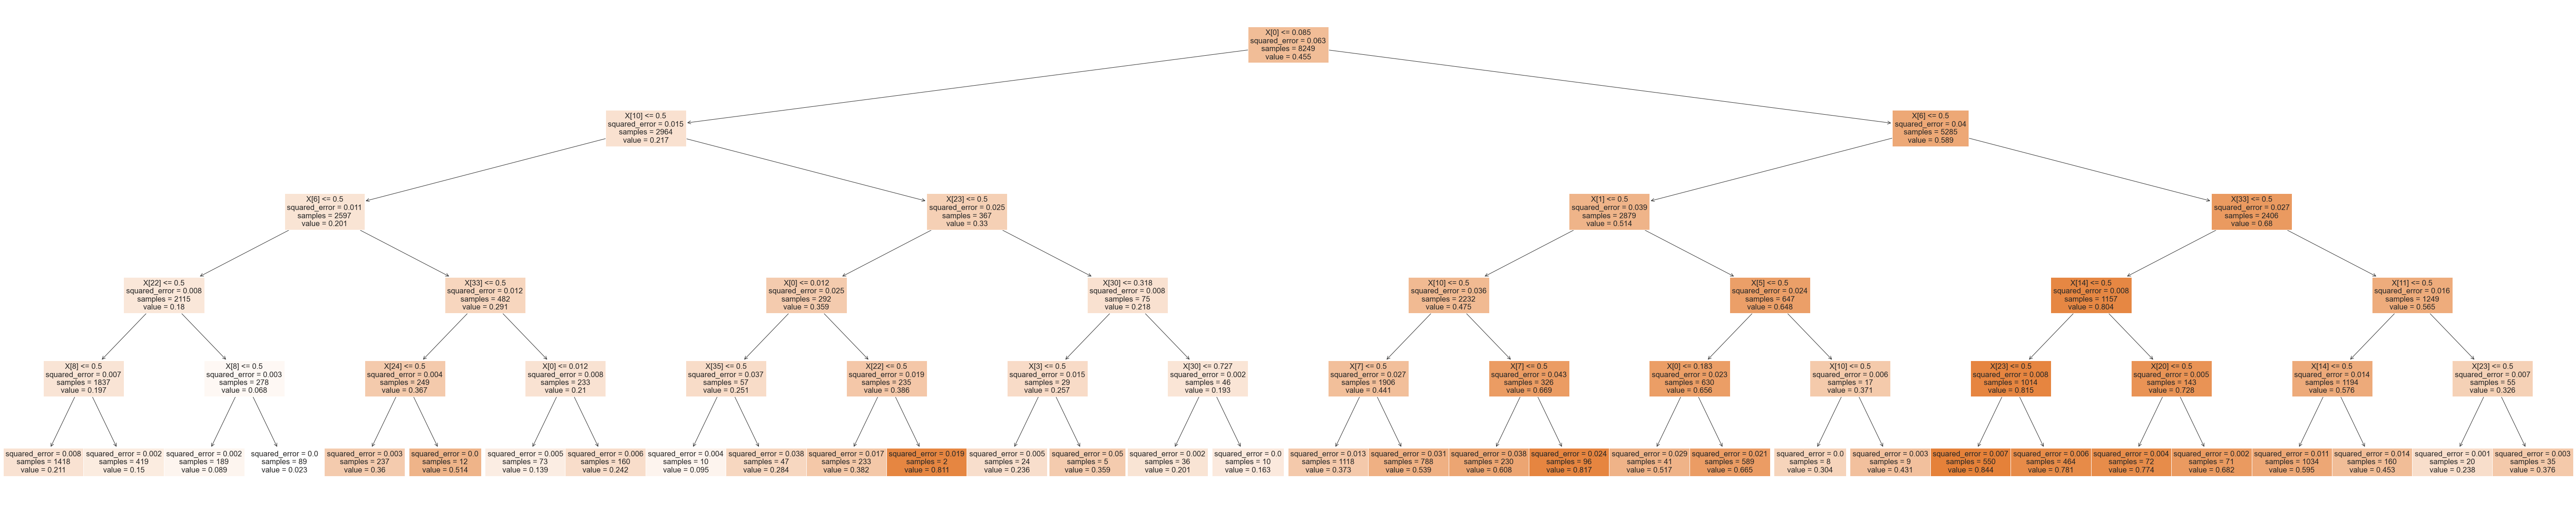

In [294]:
fig = plt.figure(figsize=(100,20))
plot = tree.plot_tree(my_DTR, filled=True)

### Random forrest regression


In [295]:
def fit_random_forrest_model(X_train,y_train):
    reg_tree = RandomForestRegressor()
    reg_tree.fit(X_train, y_train)
    return reg_tree.get_params(), reg_tree


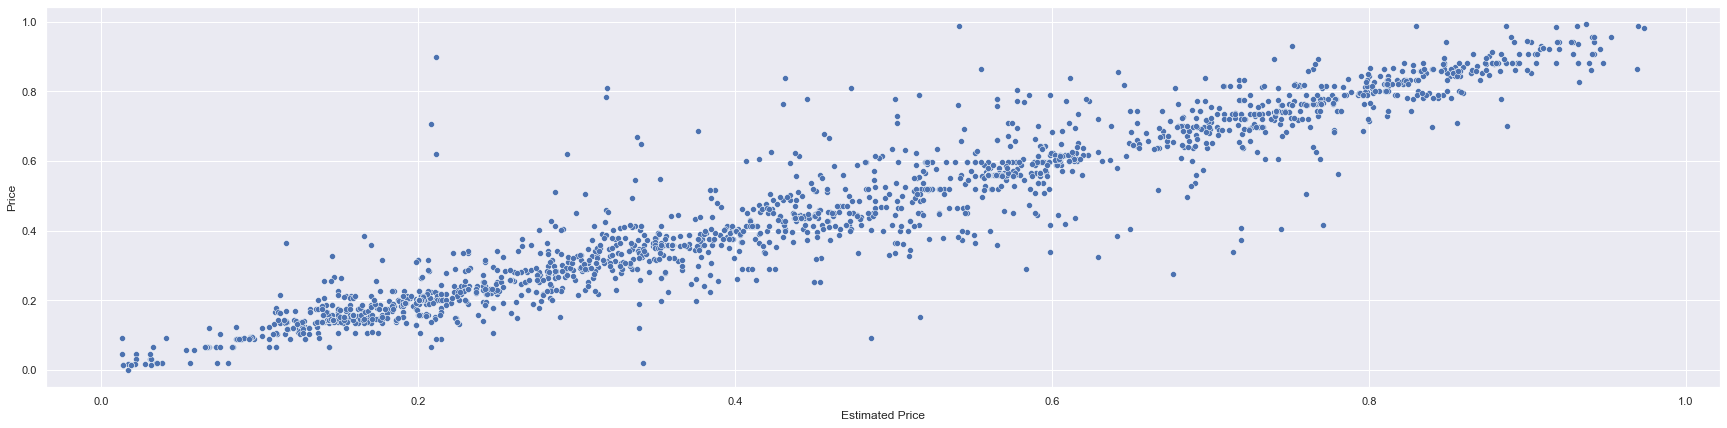

In [296]:
X_train, X_test, y_train, y_test=split_data(data_scaled)
my_RF_params,my_RF=fit_random_forrest_model(X_train, y_train)
my_RF_params_score=prediction(my_RF,X_test,y_test)
results_dict['Random forrest regression']=my_RF_params_score

### Catboost

In [297]:
def fit_catboost_model(X_train,y_train):
    cat = cb.CatBoostRegressor()
    cat.fit(X_train, y_train)
    return cat.get_params(), cat

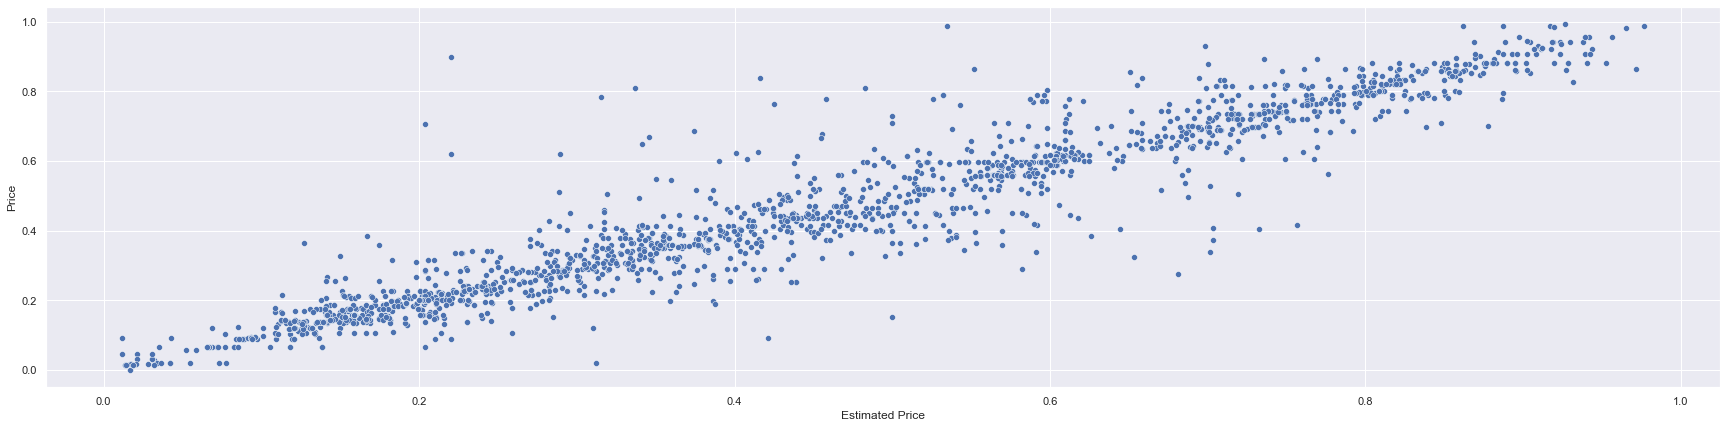

In [298]:
X_train, X_test, y_train, y_test=split_data(data_scaled)
my_cat_params,my_cat=fit_random_forrest_model(X_train, y_train)
my_cat_params_score=prediction(my_cat,X_test,y_test)
results_dict['Catboost regression']=my_cat_params_score

### XGBoost

In [299]:
def fit_xgboost_model(X_train,y_train):
    xgb = xg.XGBRegressor()
    xgb.fit(X_train, y_train)
    return xgb.get_params(), xgb

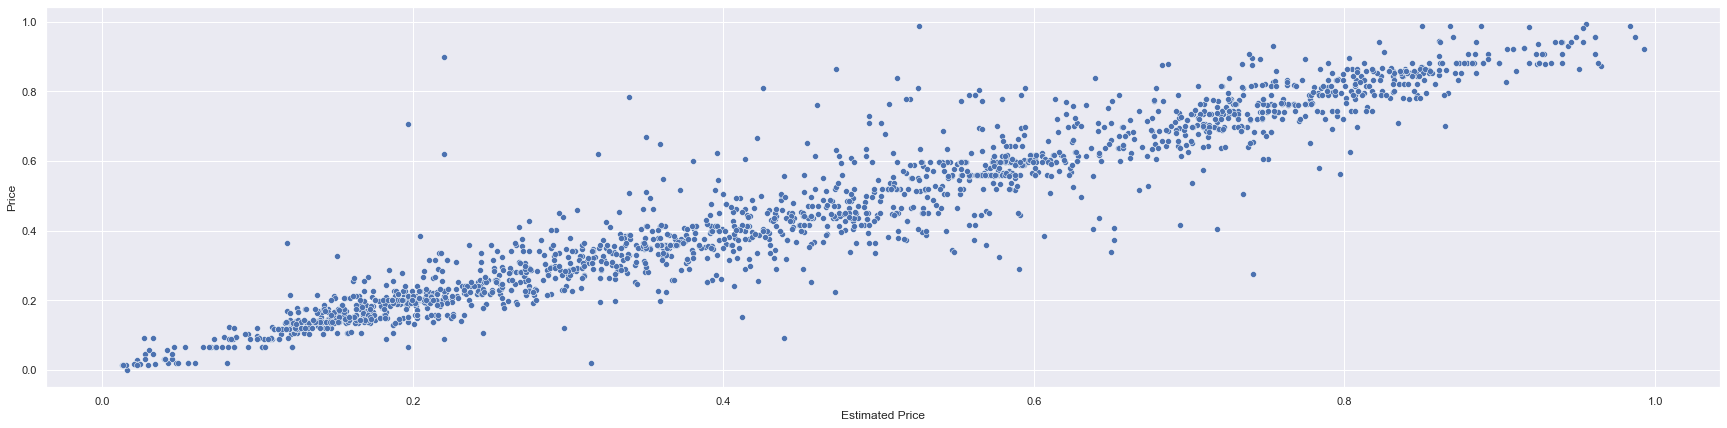

In [300]:
X_train, X_test, y_train, y_test=split_data(data_scaled)
my_xgb_params,my_xgb=fit_xgboost_model(X_train, y_train)
my_xgb_params_score=prediction(my_xgb,X_test,y_test)
results_dict['XGBoost regression']=my_xgb_params_score

In [301]:
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
scores = cross_val_score(my_xgb, X_test,y_test, cv=cv, n_jobs=-1)
scores

array([0.8927463 , 0.8267738 , 0.88265551, 0.89842009, 0.85594523,
       0.90135873, 0.79539885, 0.8785709 , 0.84916517, 0.86253079,
       0.87468396, 0.84037845, 0.85633886, 0.86063949, 0.88756622,
       0.8342296 , 0.86640643, 0.87102276, 0.87741724, 0.8990952 ,
       0.8739003 , 0.87863095, 0.86702635, 0.81812462, 0.8755454 ,
       0.84334677, 0.85038291, 0.90330884, 0.85408803, 0.89052169,
       0.8678114 , 0.78918849, 0.85878186, 0.89762515, 0.82514678,
       0.87636543, 0.87676706, 0.84912326, 0.85685935, 0.88848848,
       0.85313688, 0.85610652, 0.8387592 , 0.8945824 , 0.88266789,
       0.9009311 , 0.83888379, 0.84245976, 0.86086802, 0.89633262])

### _________________

In [302]:
results_dict

{'OLS': 0.7681808262610298,
 'Lasso': 0.7683716738373824,
 'Ridge': 0.7683716738373824,
 'Decision tree regression': 0.7933999892699004,
 'Random forrest regression': 0.917759012695412,
 'Catboost regression': 0.9199420956463767,
 'XGBoost regression': 0.9229279252050014}

Text(0.5, 0, 'XGBoost regression Feature Importance')

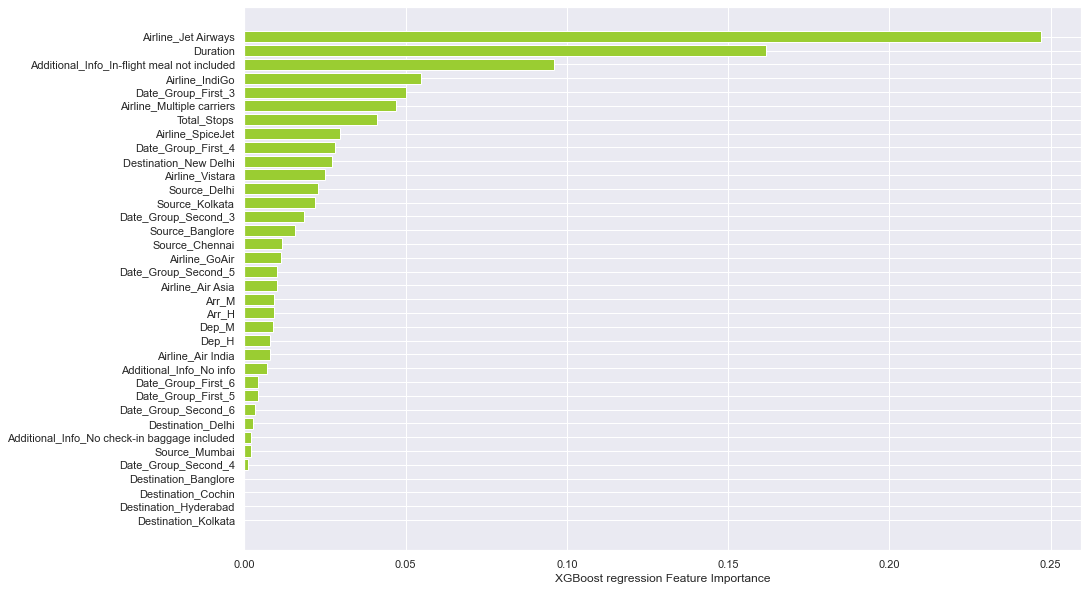

In [304]:
feature_importance = my_xgb.feature_importances_.argsort()
plt.figure(figsize=(15,10))
plt.barh(X_test.columns[feature_importance], my_xgb.feature_importances_[feature_importance], color='yellowgreen')
plt.xlabel("XGBoost regression Feature Importance")

In [306]:
import pickle
filename = 'flight_price_model.sav'
pickle.dump(my_xgb, open(filename, 'wb'))

#to load
loaded_xgb = pickle.load(open(filename, 'rb'))